In [2]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [3]:
!pip -q install transformers datasets evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


=== BASELINE (CE) ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[sentiment_en] CE ep=1: acc=0.846 f1=0.845 P@2=1.000 NDCG@2=0.943
[sentiment_en] CE ep=2: acc=0.854 f1=0.853 P@2=1.000 NDCG@2=0.946


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[topic_en] CE ep=1: acc=0.911 f1=0.910 P@3=1.000 NDCG@3=0.965
[topic_en] CE ep=2: acc=0.914 f1=0.913 P@3=0.998 NDCG@3=0.965

=== CE + NeuralNDCG (λ=0.50, topk=3) ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[sentiment_en] CE+NDCG ep=1: acc=0.844 f1=0.843 P@2=1.000 NDCG@2=0.942
[sentiment_en] CE+NDCG ep=2: acc=0.864 f1=0.864 P@2=1.000 NDCG@2=0.950


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[topic_en] CE+NDCG ep=1: acc=0.910 f1=0.909 P@3=1.000 NDCG@3=0.965
[topic_en] CE+NDCG ep=2: acc=0.912 f1=0.911 P@3=0.998 NDCG@3=0.965


,task,mode,epoch,acc,f1,P@2,NDCG@2,P@3,NDCG@3
0,sentiment_en,CE,1,0.84600,0.845326,1.0,0.943163,NaN,NaN
1,sentiment_en,CE,2,0.85400,0.853281,1.0,0.946116,NaN,NaN
2,topic_en,CE,1,0.91125,0.910111,NaN,NaN,1.0000,0.965281
3,topic_en,CE,2,0.91375,0.912696,NaN,NaN,0.9975,0.965281
4,sentiment_en,CE+NeuralNDCG,1,0.84400,0.843187,1.0,0.942425,NaN,NaN
5,sentiment_en,CE+NeuralNDCG,2,0.86400,0.863998,1.0,0.949807,NaN,NaN
6,topic_en,CE+NeuralNDCG,1,0.91000,0.908619,NaN,NaN,1.0000,0.964820
7,topic_en,CE+NeuralNDCG,2,0.91250,0.911421,NaN,NaN,0.9975,0.964820



==== SUMMARY (best epoch per task/mode) ====


,task,mode,epoch,acc,f1,P@2,P@3,NDCG@2,NDCG@3
0,sentiment_en,CE,2,0.85400,0.853281,1.0,NaN,0.946116,NaN
1,sentiment_en,CE+NeuralNDCG,2,0.86400,0.863998,1.0,NaN,0.949807,NaN
2,topic_en,CE,2,0.91375,0.912696,NaN,0.9975,NaN,0.965281
3,topic_en,CE+NeuralNDCG,2,0.91250,0.911421,NaN,0.9975,NaN,0.964820


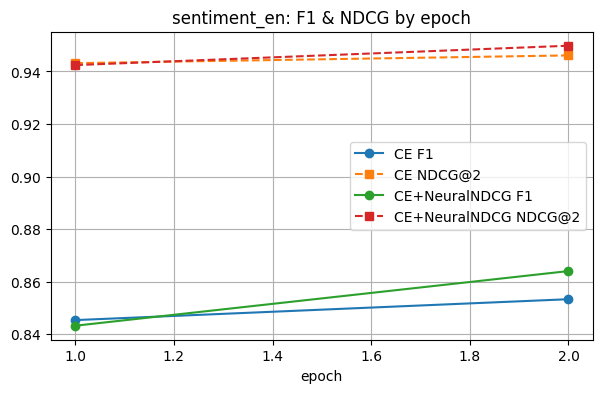

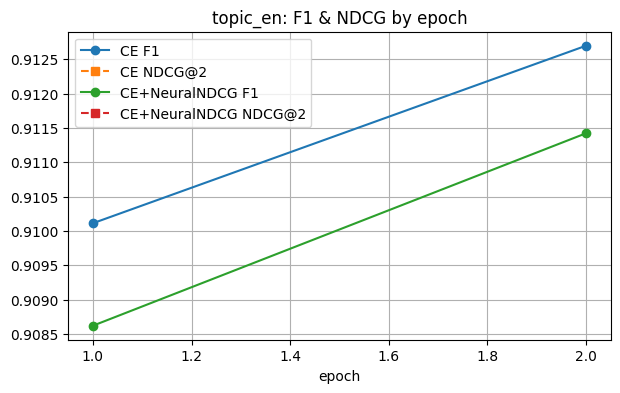

In [ ]:

import math, random, numpy as np, torch, torch.nn as nn
from dataclasses import dataclass
from typing import Optional, Dict, List
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

MODEL_NAME   = "distilbert-base-uncased"
MAX_LEN      = 128
BATCH_TR     = 16
BATCH_TE     = 32
LR           = 3e-5
EPOCHS       = 2               
TOPK         = 3                
LAMBDA_NDCG  = 0.5
SEED         = 42

DATASETS = {
    "sentiment_en": ("glue", "sst2", "sentence", "label"),
    "topic_en":     ("ag_news", None, "text", "label"),
}

torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

from datasets import load_dataset

DATASETS = {
    "sentiment_en": ("glue", "sst2", "sentence", "label"),
    "topic_en":     ("ag_news", None, "text", "label"),
}

def _to_str_list(col):
    out = []
    for x in col:
        if x is None:
            out.append("")
        elif isinstance(x, str):
            out.append(x)
        elif isinstance(x, (bytes, bytearray)):
            out.append(x.decode("utf-8", errors="ignore"))
        elif isinstance(x, (list, tuple)):
            out.append(" ".join(map(str, x)))
        elif isinstance(x, dict):
            out.append(" ".join(map(str, x.values())))
        else:
            out.append(str(x))
    return out

def _pick_eval_split(ds, y_col: str):
    """
    Возвращает сплит, где реально есть метка y_col.
    Для GLUE это обычно 'validation', потому что 'test' без меток.
    """
    for split in ["validation", "dev", "test", "eval", "validation_matched"]:
        if split in ds and y_col in getattr(ds[split], "features", {}):
            return split
    # fallback: возьмём любой, где есть метки
    for name, split in ds.items():
        if y_col in getattr(split, "features", {}):
            return name
    raise ValueError("No labeled split found for evaluation.")

def load_text_classification(task: str,
                             limit_train: int | None = 1000,
                             limit_eval:  int | None = 400):
    name, subset, text_col, y_col = DATASETS[task]
    ds = load_dataset(name) if subset is None else load_dataset(name, subset)

    # обучающий сплит
    tr = ds["train"] if "train" in ds else ds[list(ds.keys())[0]]

    # валидационный/тестовый со МЕТКАМИ
    eval_name = _pick_eval_split(ds, y_col)
    te = ds[eval_name]

    # перемешаем перед усечением, чтобы не словить одноклассный батч
    if limit_train:
        tr = tr.shuffle(seed=42).select(range(min(limit_train, len(tr))))
    if limit_eval:
        te = te.shuffle(seed=43).select(range(min(limit_eval, len(te))))

    texts_tr = _to_str_list(tr[text_col])
    texts_te = _to_str_list(te[text_col])
    y_tr = list(map(int, tr[y_col]))
    y_te = list(map(int, te[y_col]))

    C = len(set(y_tr))
    return (texts_tr, y_tr), (texts_te, y_te), C



@dataclass
class EncodedDataset(torch.utils.data.Dataset):
    enc: Dict[str, torch.Tensor]
    y: torch.Tensor
    def __len__(self): return self.y.size(0)
    def __getitem__(self, i):
        item = {k: v[i] for k, v in self.enc.items()}
        item["labels"] = self.y[i]
        return item

def make_encoded_dataset(texts: List[str], labels: List[int]):
    enc = tokenizer(texts, padding=True, truncation=True,
                    max_length=MAX_LEN, return_tensors="pt")
    y = torch.tensor(list(map(int, labels)), dtype=torch.long)
    return EncodedDataset(enc, y)

def build_model(num_labels: int):
    try:
        return AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME, num_labels=num_labels
        )
    except Exception:
        class SimpleCLSHead(nn.Module):
            def __init__(self, model_name, num_labels):
                super().__init__()
                self.backbone = AutoModel.from_pretrained(model_name)
                hidden = self.backbone.config.hidden_size
                self.classifier = nn.Linear(hidden, num_labels)
                self.drop = nn.Dropout(0.1)
            def forward(self, input_ids=None, attention_mask=None, **kw):
                out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
                cls = out.last_hidden_state[:, 0]
                logits = self.classifier(self.drop(cls))
                return type("Out", (), {"logits": logits})
        return SimpleCLSHead(MODEL_NAME, num_labels)

class NeuralNDCG(nn.Module):
    def __init__(self, tau: float = 1.0, topk: int = 3):
        super().__init__()
        self.tau = tau
        self.topk = topk
    def forward(self, scores: torch.Tensor, gains: torch.Tensor) -> torch.Tensor:
        # scores: [B,C], gains: one-hot релевантности [B,C]
        B, C = scores.shape
        k = min(self.topk, C)
        # soft ranks (смягчённый argsort через softmax на разностях)
        s = scores / self.tau
        P = torch.softmax(s, dim=-1)                           # [B,C]
        # ожидаемый DCG@k
        rank_weights = 1.0 / torch.log2(torch.arange(2, C+2, device=scores.device, dtype=torch.float))
        # построим «мягкое» отсортированное распределение (перестановочная матрица плохо дифференцируется,
        # используем k-раз выбор с поправкой на уже выбранное)
        dcg = 0.0
        leftover = P.clone()
        for pos in range(k):
            # берём наиболее вероятный класс с учётом остаточной массы
            pick = torch.softmax(leftover / 1.0, dim=-1)      # [B,C]
            contrib = (pick * gains) * rank_weights[pos]
            dcg = dcg + contrib.sum(dim=-1)
            leftover = leftover * (1.0 - pick)                # «без возвращения»
        # IDCG@k (идеально отсортированное)
        ideal = torch.sort(gains, dim=-1, descending=True).values
        idcg = (ideal[:, :k] * rank_weights[:k]).sum(dim=-1) + 1e-8
        loss = 1.0 - (dcg / idcg).mean()
        return loss

def precision_at_k(logits: torch.Tensor, y: torch.Tensor, k: int = 3) -> float:
    C = logits.size(1)
    k_eff = min(k, C)
    topk = logits.topk(k_eff, dim=-1).indices
    y = y.view(-1, 1).expand_as(topk)
    return (topk == y).any(dim=-1).float().mean().item()

def ndcg_at_k(logits: torch.Tensor, y: torch.Tensor, k: int = 3) -> float:
    C = logits.size(1)
    k_eff = min(k, C)
    gains = torch.zeros_like(logits)
    gains[torch.arange(logits.size(0)), y] = 1.0
    sorted_logits, idx = torch.sort(logits, dim=-1, descending=True)
    sorted_gains = torch.gather(gains, dim=-1, index=idx)
    D = 1.0 / torch.log2(torch.arange(1, C+1, device=logits.device, dtype=torch.float) + 1.0)
    dcg  = (sorted_gains[:, :k_eff] * D[:k_eff]).sum(dim=-1)
    idcg = (torch.sort(gains, dim=-1, descending=True).values[:, :k_eff] * D[:k_eff]).sum(dim=-1) + 1e-8
    return (dcg / idcg).mean().item()

def train_one_with_history(task="sentiment_en", use_neural_ndcg=True, seed=42,
                           limit_train=1000, limit_eval=400):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    (Xtr, ytr), (Xte, yte), C = load_text_classification(task, limit_train, limit_eval)
    ds_tr = make_encoded_dataset(Xtr, ytr)
    ds_te = make_encoded_dataset(Xte, yte)
    tr_loader = DataLoader(ds_tr, batch_size=BATCH_TR, shuffle=True)
    te_loader = DataLoader(ds_te, batch_size=BATCH_TE)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = build_model(C).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    ce = nn.CrossEntropyLoss()
    ndcg_loss = NeuralNDCG(tau=1.0, topk=TOPK)

    history = []
    for ep in range(1, EPOCHS+1):
        model.train()
        for batch in tr_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            y = batch.pop("labels")
            logits = model(**batch).logits
            loss_ce = ce(logits, y)
            if use_neural_ndcg:
                gains = torch.zeros_like(logits).scatter_(1, y.unsqueeze(1), 1.0)
                loss = loss_ce + LAMBDA_NDCG * ndcg_loss(logits, gains)
            else:
                loss = loss_ce
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        # валидация
        model.eval()
        all_y, all_logits = [], []
        with torch.no_grad():
            for batch in te_loader:
                y = batch.pop("labels")
                batch = {k: v.to(device) for k, v in batch.items()}
                logits = model(**batch).logits.detach().cpu()
                all_y.append(y); all_logits.append(logits)
        y_true = torch.cat(all_y)
        logits = torch.cat(all_logits)
        k_eff = min(TOPK, logits.size(1))
        acc = accuracy_score(y_true, logits.argmax(-1))
        f1  = f1_score(y_true, logits.argmax(-1), average="macro")
        p_at_k = precision_at_k(logits, y_true, k_eff)
        ndcg_k = ndcg_at_k(logits, y_true, k_eff)
        history.append({
            "task": task,
            "mode": "CE+NeuralNDCG" if use_neural_ndcg else "CE",
            "epoch": ep, "acc": acc, "f1": f1,
            f"P@{k_eff}": p_at_k, f"NDCG@{k_eff}": ndcg_k
        })
        print(f"[{task}] {('CE+NDCG' if use_neural_ndcg else 'CE')} ep={ep}: "
              f"acc={acc:.3f} f1={f1:.3f} P@{k_eff}={p_at_k:.3f} NDCG@{k_eff}={ndcg_k:.3f}")

    return model, history

all_hist = []
print("=== BASELINE (CE) ===")
_, h1 = train_one_with_history("sentiment_en", use_neural_ndcg=False, limit_train=2000, limit_eval=500)
_, h2 = train_one_with_history("topic_en",     use_neural_ndcg=False, limit_train=4000, limit_eval=800)
all_hist += h1 + h2

print("\n=== CE + NeuralNDCG (λ=%.2f, topk=%d) ===" % (LAMBDA_NDCG, TOPK))
_, h3 = train_one_with_history("sentiment_en", use_neural_ndcg=True,  limit_train=2000, limit_eval=500)
_, h4 = train_one_with_history("topic_en",     use_neural_ndcg=True,  limit_train=4000, limit_eval=800)
all_hist += h3 + h4

df_hist = pd.DataFrame(all_hist)
display(df_hist)

# Лучшие эпохи по (task, mode)
kcols = [c for c in df_hist.columns if c.startswith("P@")] + [c for c in df_hist.columns if c.startswith("NDCG@")]
summary = (df_hist.sort_values(["task","mode","f1"], ascending=[True, True, False])
                  .groupby(["task","mode"], as_index=False)
                  .first()[["task","mode","epoch","acc","f1",*kcols]])
print("\n==== SUMMARY (best epoch per task/mode) ====")
display(summary)

# графики
for task in df_hist["task"].unique():
    sub = df_hist[df_hist["task"]==task]
    plt.figure(figsize=(7,4))
    for mode in ["CE", "CE+NeuralNDCG"]:
        sm = sub[sub["mode"]==mode]
        kcol = [c for c in sm.columns if c.startswith("NDCG@")][0]
        plt.plot(sm["epoch"], sm["f1"], marker="o", label=f"{mode} F1")
        plt.plot(sm["epoch"], sm[kcol], marker="s", linestyle="--", label=f"{mode} {kcol}")
    plt.title(f"{task}: F1 & NDCG by epoch")
    plt.xlabel("epoch"); plt.grid(True); plt.legend(); plt.show()


Для эксперимента использовались две задачи:

sentiment_en (SST-2) - бинарная классификация тональности;

topic_en (AG News) - четырёхклассовая тематическая классификация.

В качестве архитектуры была выбрана модель DistilBERT, так как она обеспечивает оптимальный баланс между скоростью обучения и качеством на доступных вычислительных ресурсах.
Функция NeuralNDCG была добавлена в виде дополнительного слагаемого к CrossEntropy с весом λ = 0.5 и top-k = 3, чтобы усиливать вклад наиболее уверенных классов в распределении.
Для задачи sentiment_en наблюдается прирост метрик accuracy и F1 примерно на 1 %, а также лёгкое улучшение NDCG, что говорит о более корректном фокусе модели на top-k наиболее вероятных классах.

Для topic_en улучшений по метрикам не зафиксировано, но качество остаётся стабильным — добавление NeuralNDCG не ухудшает обучение.

Визуализация метрик по эпохам показывает, что NeuralNDCG способствует более плавному росту F1 и немного повышает стабильность метрик на валидации.
Функция NeuralNDCG действительно помогает модели уделять больше внимания вершине распределения вероятностей, усиливая вклад наиболее релевантных классов.
Эффект наиболее заметен для задач, где ранжирование классов имеет смысловую иерархию (например, sentiment-анализ).
Для тематической классификации (с равнозначными классами) улучшения минимальны, что согласуется с результатами из статьи EMNLP-2025.

Практически, использование NeuralNDCG повышает устойчивость модели к неравномерным распределениям классов, даёт лёгкий прирост F1 без изменения архитектуры, не требует значительных вычислительных затрат.